In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/big-mart-sales-prediction-datasets/sample_submission.csv
/kaggle/input/big-mart-sales-prediction-datasets/train.csv
/kaggle/input/big-mart-sales-prediction-datasets/test.csv


> Importing the Dependencies


In [175]:
import pandas as pd 
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Data Collection and Analysis

In [15]:
# loading the data set ffrom csv file to pandas data frame 
big_mart_data = pd.read_csv('/kaggle/input/big-mart-sales-prediction-datasets/train.csv')

In [16]:
# first five rows of the data frame 
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
# number of data points and number of features
big_mart_data.shape

(8523, 12)

In [18]:
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


>  Categorical Features 

1. Item_Identifier 
2. Item_Fat_Content
3. Item_Type
4. Outlet_Identifier
5. Outlet_Size
6. Outlet_Location_Type
7. Outlet_Type


In [19]:
# checking for missing values 
big_mart_data.isnull().sum()  

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

> Handing Missing Values 

In [157]:
# imputing the missing values 
# mean value of Item_Weight 
big_mart_data['Item_Weight'].mean()

12.857645184135976

In [158]:
# Instead of using inplace=True, directly assign the result back to the column
big_mart_data['Item_Weight'] = big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean())


In [159]:
big_mart_data.isnull().sum()  

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [160]:
# imputing for Outlet_Size 
mode_of_outlet_size = big_mart_data.pivot_table(values='Outlet_Size',columns='Outlet_Type' ,aggfunc=(lambda x: x.mode()[0]))

In [161]:
print(mode_of_outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [162]:
missing_values = big_mart_data['Outlet_Size'].isnull()

In [163]:
print(missing_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [164]:
big_mart_data.loc[missing_values, 'Outlet_Size'] = big_mart_data.loc[missing_values , 'Outlet_Type'].apply(lambda x: mode_of_outlet_size )


In [165]:
big_mart_data.isnull().sum() 

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [145]:
big_mart_data.describe()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523.000000,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,779.714889,12.857645,0.352693,0.066132,7.226681,140.992782,4.722281,1997.831867,1.736360,1.112871,1.201220,2181.288914
std,449.222377,4.643456,0.477836,0.051598,4.209990,62.275067,2.837201,8.371760,0.989181,0.812757,0.796459,1706.499616
min,0.000000,4.555000,0.000000,0.000000,0.000000,31.290000,0.000000,1985.000000,0.000000,0.000000,0.000000,33.290000
25%,395.500000,8.773750,0.000000,0.026989,4.000000,93.826500,2.000000,1987.000000,1.000000,0.000000,1.000000,834.247400
50%,783.000000,12.600000,0.000000,0.053931,6.000000,143.012800,5.000000,1999.000000,2.000000,1.000000,1.000000,1794.331000
75%,1167.000000,16.850000,1.000000,0.094585,10.000000,185.643700,7.000000,2004.000000,3.000000,2.000000,1.000000,3101.296400
max,1558.000000,21.350000,1.000000,0.328391,15.000000,266.888400,9.000000,2009.000000,3.000000,2.000000,3.000000,13086.964800


> Numerical Features

In [ ]:
sns.set()

<Figure size 600x600 with 0 Axes>

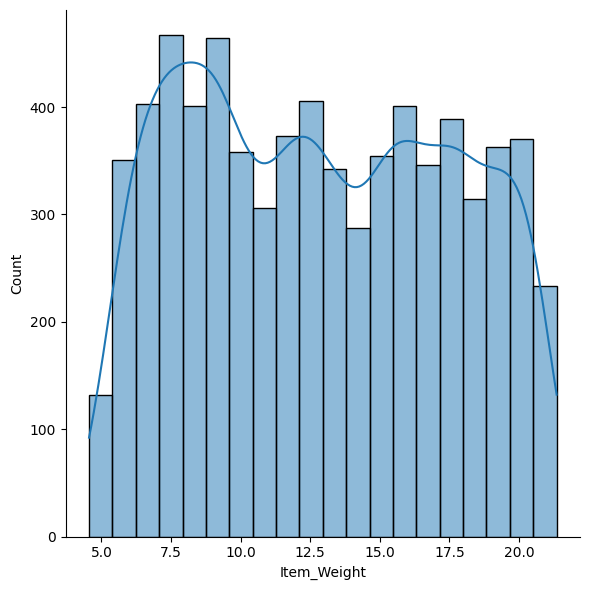

In [155]:
# Item_Weight distribution
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(6,6))
sns.displot(big_mart_data['Item_Weight'], kde=True, height=6, aspect=1)  # `height` and `aspect` control the figure size
plt.show()

<Figure size 600x600 with 0 Axes>

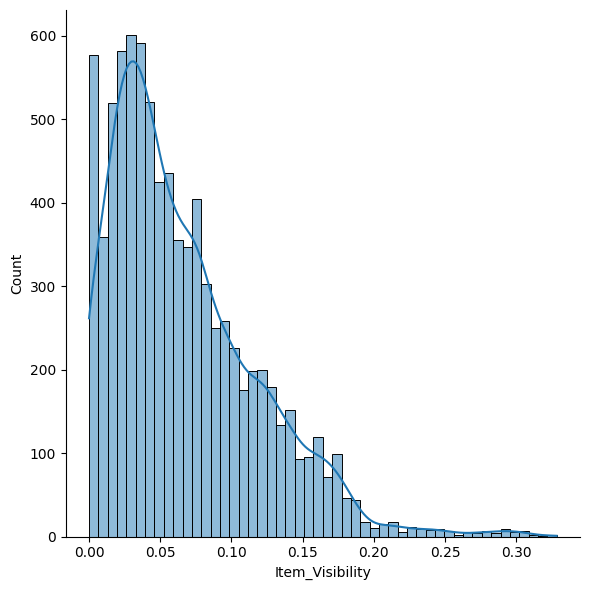

In [56]:
# Item_Visibility distribution
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(6,6))
sns.displot(big_mart_data['Item_Visibility'], kde=True, height=6, aspect=1)  # `height` and `aspect` control the figure size
plt.show()

<Figure size 600x600 with 0 Axes>

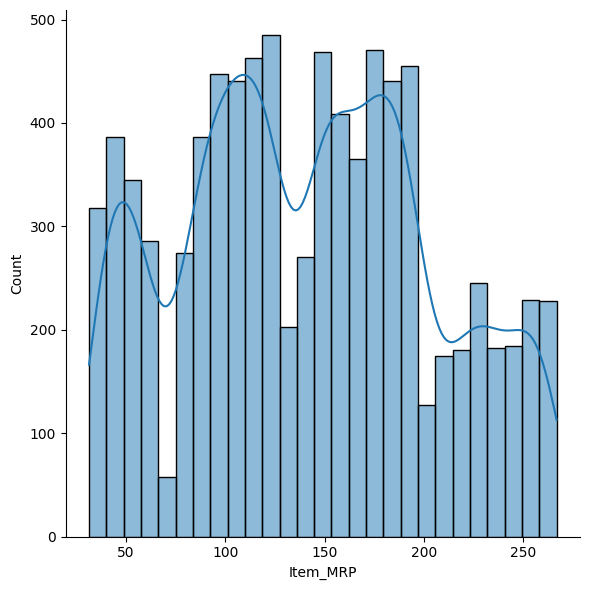

In [57]:
# Item_MRP distribution
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(6,6))
sns.displot(big_mart_data['Item_MRP'], kde=True, height=6, aspect=1)  # `height` and `aspect` control the figure size
plt.show()

<Figure size 600x600 with 0 Axes>

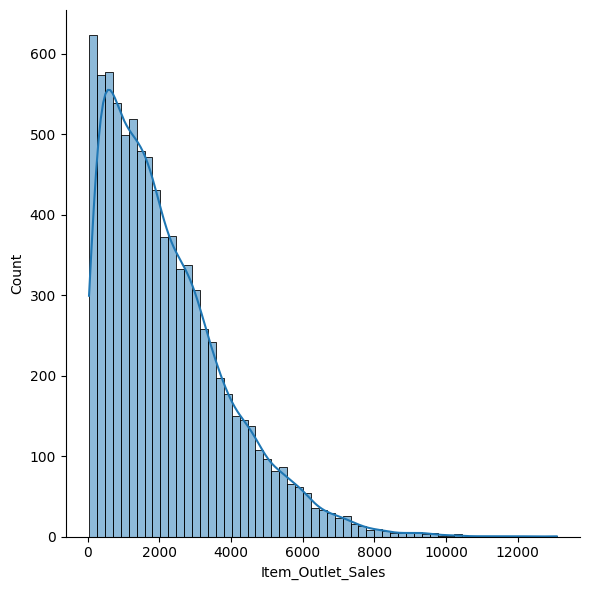

In [58]:
# Item_Outlet_Sales distribution
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(6,6))
sns.displot(big_mart_data['Item_Outlet_Sales'], kde=True, height=6, aspect=1)  # `height` and `aspect` control the figure size
plt.show()

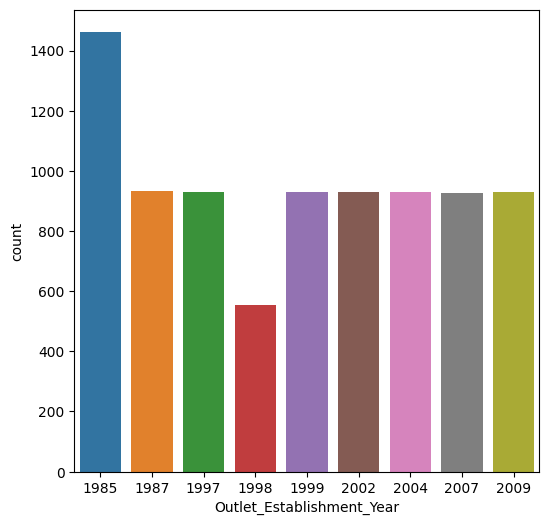

In [59]:
# Outlet_Establishment_Year

plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data )
plt.show()

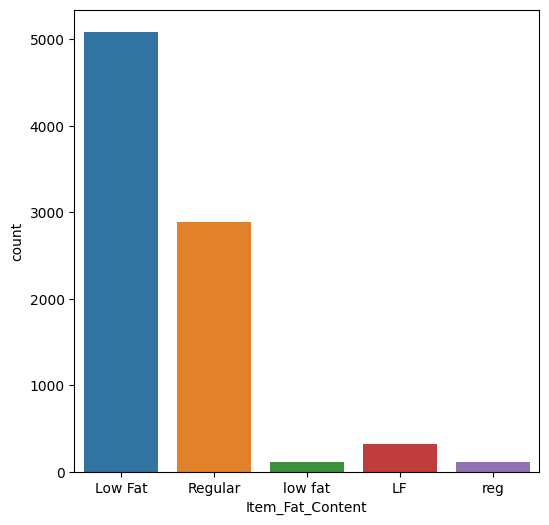

In [62]:
# Item_Fat_Content

plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data )
plt.show()

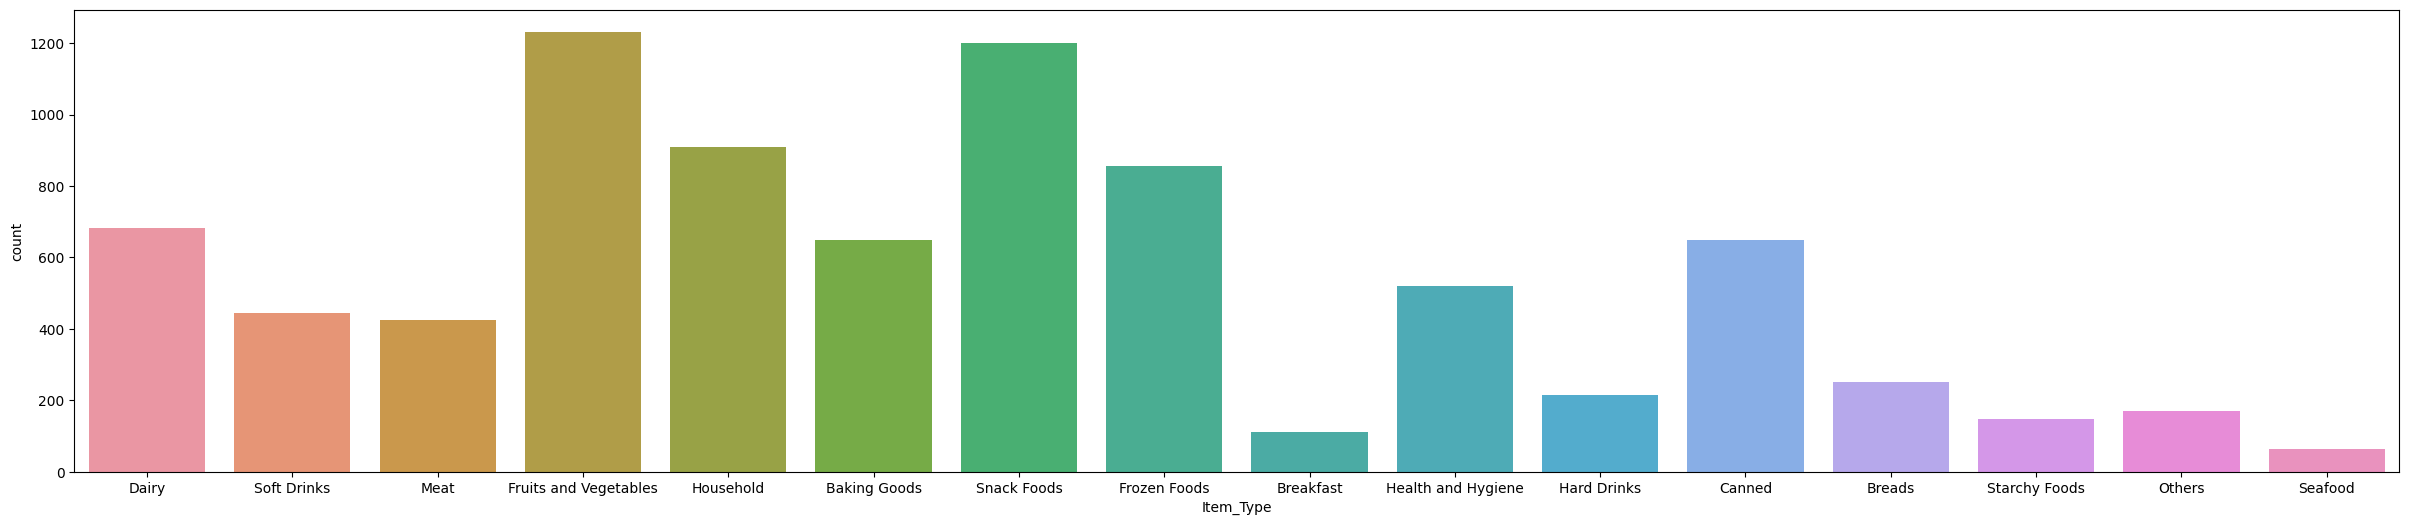

In [64]:
# Item_Type

plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data )
plt.show()

  Outlet_Size
0       Small
1      Medium
2       Large
4       Small
6      Medium
7       Small


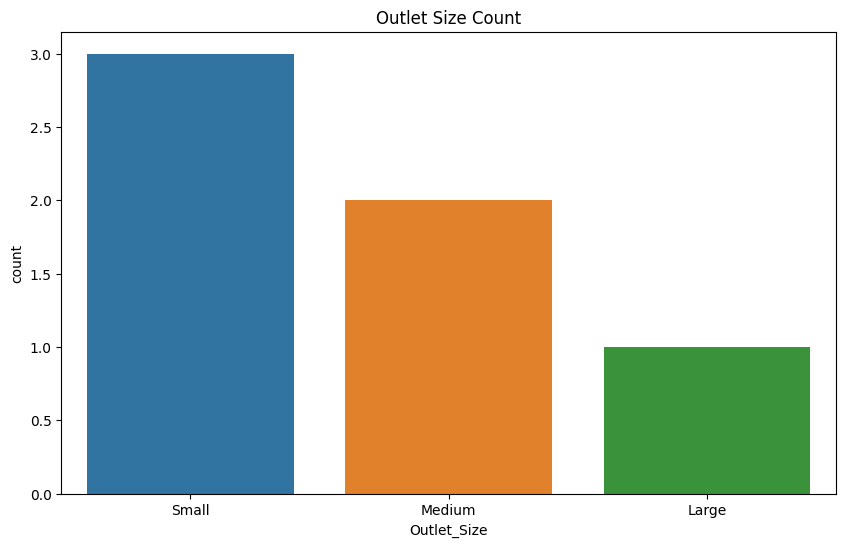

In [78]:
# Outlet_Size column

# Example DataFrame (replace with your actual DataFrame)
data = {
    'Outlet_Size': ['Small', 'Medium', 'Large', None, 'Small', np.nan, 'Medium', 'Small']
}
big_mart_data = pd.DataFrame(data)

# Ensure all 'NaN' strings and other unusual missing values are treated as NaN
big_mart_data['Outlet_Size'].replace(['nan', 'None', ''], np.nan, inplace=True)

# Filter out rows where 'Outlet_Size' is NaN
filtered_data = big_mart_data.dropna(subset=['Outlet_Size'])

# Verify the filtered data
print(filtered_data)

# Plot the data without NaN values
plt.figure(figsize=(10,6))
sns.countplot(x='Outlet_Size', data=filtered_data)
plt.title('Outlet Size Count')
plt.show()

# Data Pre-processing

In [153]:
big_mart_data = pd.read_csv('/kaggle/input/big-mart-sales-prediction-datasets/train.csv')
big_mart_data.head() 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [82]:
big_mart_data['Item_Fat_Content'].value_counts()


Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [88]:

# standardizing the values 
big_mart_data.replace({'Item_Fat_Content': {'low fat' : 'Low Fat', 'LF': 'Low Fat', 'reg':'Regular','Low fat' : 'Low Fat' }}, inplace =True)
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [90]:
# let's use label encoding 
encoder = LabelEncoder()

In [92]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])
big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])
big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])
big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])
big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])
big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

big_mart_data.head() 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,3,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


> Splitting Features and Target

In [93]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [95]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [96]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


> **Splitting the data into Training & Testing data** 

In [129]:
X_train, X_test, Y_train , Y_test = train_test_split(X, Y, test_size=0.2 , random_state = 2)

In [130]:
print(X.shape, X_train.shape , X_test.shape )

(8523, 11) (6818, 11) (1705, 11)


# Machine Learning Model Training

In [221]:
# # XGBoost not preferable because its complexity resulted high difference of r squared value
# regressor = XGBRegressor()
# regressor.fit(X_train , Y_train) # for xgboost 


model = LinearRegression()
model.fit(X_train, Y_train)


LinearRegression()

In [212]:
y_pred = model.predict(X_test)

**Evaluation**

In [223]:
# prediction on training sets 
training_data_prediction = model.predict(X_train)

In [224]:
# R squared value 
r2_train = metrics.r2_score(Y_train,training_data_prediction)

In [225]:
print('R squared value - ',r2_train )

R squared value -  0.5057228963728915


In [226]:
# prediction on training sets 
test_data_prediction =model.predict(X_test)

In [227]:
# R squared value 
r2_test = metrics.r2_score(Y_test,test_data_prediction)

In [228]:
print('R squared value - ',r2_test )

R squared value -  0.4867823923484055
